In [1]:
# Install required libraries
!pip install pandas numpy matplotlib seaborn scikit-learn plotly -q

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries installed!")

✅ Libraries installed!


In [5]:
# Load the customer segmentation dataset
# METHOD 1: Upload from your computer
from google.colab import files
import io

uploaded = files.upload()

# Get filename
filename = list(uploaded.keys())[0]
print(f"📂 File: {filename}")

# Try different encodings for CSV
try:
    df = pd.read_csv(io.BytesIO(uploaded[filename]), encoding='utf-8')
    print("✅ Loaded with UTF-8")
except:
    try:
        df = pd.read_csv(io.BytesIO(uploaded[filename]), encoding='latin1')
        print("✅ Loaded with Latin-1")
    except:
        try:
            df = pd.read_excel(io.BytesIO(uploaded[filename]))
            print("✅ Loaded as Excel")
        except:
            df = pd.read_csv(io.BytesIO(uploaded[filename]), encoding='utf-8', errors='ignore')
            print("✅ Loaded ignoring errors")

print(f"\n📊 Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")

Saving Twitter_Data.csv to Twitter_Data.csv
📂 File: Twitter_Data.csv
✅ Loaded with UTF-8

📊 Dataset loaded: 162980 rows × 2 columns


In [6]:
print("="*80)
print("STEP 1: DATA EXPLORATION")
print("="*80)

# 1. Basic information
print("📋 DATASET INFORMATION:")
print(f"Shape: {df.shape}")
print(f"\nColumn Names:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col}")

# 2. Data types
print("\n🔧 DATA TYPES:")
print(df.dtypes)

# 3. First look at data
print("\n👀 FIRST 5 ROWS:")
print(df.head())

# 4. Check for missing values
print("\n❌ MISSING VALUES CHECK:")
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Values': missing,
    'Percentage': missing_percent
}).sort_values('Percentage', ascending=False)

print(missing_df[missing_df['Missing_Values'] > 0])

# 5. Basic statistics
print("\n📈 BASIC STATISTICS:")
print(df.describe())

STEP 1: DATA EXPLORATION
📋 DATASET INFORMATION:
Shape: (162980, 2)

Column Names:
   1. clean_text
   2. category

🔧 DATA TYPES:
clean_text     object
category      float64
dtype: object

👀 FIRST 5 ROWS:
                                          clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0

❌ MISSING VALUES CHECK:
            Missing_Values  Percentage
category                 7    0.004295
clean_text               4    0.002454

📈 BASIC STATISTICS:
            category
count  162973.000000
mean        0.225436
std         0.781279
min        -1.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000


In [7]:
print("="*80)
print("STEP 2: DATA CLEANING")
print("="*80)

# Make a copy for cleaning
df_clean = df.copy()
original_shape = df_clean.shape

# 1. Handle missing values
print("🧹 HANDLING MISSING VALUES...")
for column in df_clean.columns:
    if df_clean[column].isnull().sum() > 0:
        dtype = df_clean[column].dtype
        if dtype in ['int64', 'float64']:
            # Fill numeric with median
            df_clean[column].fillna(df_clean[column].median(), inplace=True)
        else:
            # Fill categorical with mode
            mode_val = df_clean[column].mode()[0] if not df_clean[column].mode().empty else 'Unknown'
            df_clean[column].fillna(mode_val, inplace=True)
        print(f"  ✅ {column}: Filled {df_clean[column].isnull().sum()} missing values")

# 2. Remove duplicates
print("\n🔍 CHECKING DUPLICATES...")
duplicates = df_clean.duplicated().sum()
if duplicates > 0:
    df_clean = df_clean.drop_duplicates()
    print(f"  ✅ Removed {duplicates} duplicate rows")
else:
    print("  ✅ No duplicates found")

# 3. Check data types
print("\n🔧 CHECKING DATA TYPES...")
for column in df_clean.columns:
    if df_clean[column].dtype == 'object':
        # Check if it's actually numeric
        try:
            pd.to_numeric(df_clean[column], errors='raise')
            df_clean[column] = pd.to_numeric(df_clean[column])
            print(f"  ✅ {column}: Converted to numeric")
        except:
            # Clean text data
            df_clean[column] = df_clean[column].astype(str).str.strip()
            print(f"  ✅ {column}: Cleaned text data")

print(f"\n🎯 CLEANING COMPLETE!")
print(f"Original shape: {original_shape}")
print(f"Cleaned shape:  {df_clean.shape}")
print(f"Missing values: {df_clean.isnull().sum().sum()}")

STEP 2: DATA CLEANING
🧹 HANDLING MISSING VALUES...
  ✅ clean_text: Filled 0 missing values
  ✅ category: Filled 0 missing values

🔍 CHECKING DUPLICATES...
  ✅ Removed 2 duplicate rows

🔧 CHECKING DATA TYPES...
  ✅ clean_text: Cleaned text data

🎯 CLEANING COMPLETE!
Original shape: (162980, 2)
Cleaned shape:  (162978, 2)
Missing values: 0


In [8]:
print("="*80)
print("STEP 3: RFM ANALYSIS (Recency, Frequency, Monetary)")
print("="*80)

# Identify key columns for RFM
print("📊 IDENTIFYING KEY COLUMNS:")
for col in df_clean.columns:
    col_lower = str(col).lower()
    if any(keyword in col_lower for keyword in ['date', 'time', 'purchase', 'order']):
        print(f"  📅 Date/Time column: {col}")
    if any(keyword in col_lower for keyword in ['amount', 'price', 'revenue', 'sales', 'total']):
        print(f"  💰 Monetary column: {col}")
    if any(keyword in col_lower for keyword in ['id', 'customer', 'client', 'user']):
        print(f"  👤 Customer ID column: {col}")

# Let user input column names
customer_id = input("\nEnter Customer ID column name (or press Enter to skip): ") or None
date_column = input("Enter Purchase Date column name (or press Enter to skip): ") or None
amount_column = input("Enter Purchase Amount column name (or press Enter to skip): ") or None

# If columns found, perform RFM analysis
if customer_id and date_column and amount_column:
    print("\n🎯 PERFORMING RFM ANALYSIS...")

    # Convert date column
    df_clean[date_column] = pd.to_datetime(df_clean[date_column])

    # Calculate RFM metrics
    current_date = df_clean[date_column].max() + pd.Timedelta(days=1)

    rfm = df_clean.groupby(customer_id).agg({
        date_column: lambda x: (current_date - x.max()).days,  # Recency
        customer_id: 'count',  # Frequency
        amount_column: 'sum'   # Monetary
    }).rename(columns={
        date_column: 'Recency',
        customer_id: 'Frequency',
        amount_column: 'Monetary'
    })

    print("\n📊 RFM METRICS SUMMARY:")
    print(rfm.describe())

    # Visualize RFM distributions
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].hist(rfm['Recency'], bins=20, edgecolor='black', alpha=0.7)
    axes[0].set_title('Recency Distribution')
    axes[0].set_xlabel('Days since last purchase')
    axes[0].set_ylabel('Count')

    axes[1].hist(rfm['Frequency'], bins=20, edgecolor='black', alpha=0.7)
    axes[1].set_title('Frequency Distribution')
    axes[1].set_xlabel('Number of purchases')
    axes[1].set_ylabel('Count')

    axes[2].hist(rfm['Monetary'], bins=20, edgecolor='black', alpha=0.7)
    axes[2].set_title('Monetary Distribution')
    axes[2].set_xlabel('Total spending')
    axes[2].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

    # Use RFM for segmentation
    X = rfm[['Recency', 'Frequency', 'Monetary']]
else:
    print("\n⚠️ RFM analysis skipped. Using all numeric features for segmentation.")
    # Select all numeric columns for segmentation
    numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
    if len(numeric_cols) > 0:
        X = df_clean[numeric_cols]
        print(f"Using numeric columns: {list(numeric_cols)}")
    else:
        # If no numeric columns, create some
        print("⚠️ No numeric columns found. Creating features from available data...")
        for col in df_clean.columns:
            if df_clean[col].dtype == 'object':
                df_clean[col + '_encoded'] = pd.factorize(df_clean[col])[0]
        numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
        X = df_clean[numeric_cols]

STEP 3: RFM ANALYSIS (Recency, Frequency, Monetary)
📊 IDENTIFYING KEY COLUMNS:

Enter Customer ID column name (or press Enter to skip): 
Enter Purchase Date column name (or press Enter to skip): 
Enter Purchase Amount column name (or press Enter to skip): 

⚠️ RFM analysis skipped. Using all numeric features for segmentation.
Using numeric columns: ['category']


In [10]:
print("="*80)
print("STEP 4: FEATURE SCALING")
print("="*80)

# Check for outliers before scaling
print("🔍 CHECKING FOR OUTLIERS...")
for col in X.columns:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((X[col] < (Q1 - 1.5 * IQR)) | (X[col] > (Q3 + 1.5 * IQR))).sum()
    if outliers > 0:
        print(f"  ⚠️ {col}: {outliers} outliers detected ({outliers/len(X)*100:.1f}%)")

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\n✅ Features scaled: {X_scaled.shape[1]} features")
print(f"Feature mean after scaling: {X_scaled.mean():.2f}")
print(f"Feature std after scaling: {X_scaled.std():.2f}")

STEP 4: FEATURE SCALING
🔍 CHECKING FOR OUTLIERS...

✅ Features scaled: 1 features
Feature mean after scaling: 0.00
Feature std after scaling: 1.00


In [15]:
print("="*80)
print("DEBUGGING INFO")
print("="*80)

print(f"1. X_scaled shape: {X_scaled.shape}")
print(f"2. X_scaled type: {type(X_scaled)}")
print(f"3. X_scaled has NaN: {np.isnan(X_scaled).any()}")
print(f"4. X_scaled has Inf: {np.isinf(X_scaled).any()}")
print(f"5. Sample of X_scaled:")
print(X_scaled[:3])

# Fix any issues
if np.isnan(X_scaled).any() or np.isinf(X_scaled).any():
    print("\n⚠️ Fixing NaN/Inf values...")
    X_scaled = np.nan_to_num(X_scaled)

if X_scaled.shape[0] < 2:
    print("\n❌ Not enough data points for clustering!")
    # Create dummy data for testing
    print("Creating sample data for demonstration...")
    np.random.seed(42)
    X_scaled = np.random.randn(100, 3)  # 100 samples, 3 features

DEBUGGING INFO
1. X_scaled shape: (162978, 1)
2. X_scaled type: <class 'numpy.ndarray'>
3. X_scaled has NaN: False
4. X_scaled has Inf: False
5. Sample of X_scaled:
[[-1.56851899]
 [-0.28854378]
 [ 0.99143142]]


STEP 5: AUTOMATIC CLUSTER DETERMINATION
Based on sample size (162978), using k=5

📊 Quick test of different k values:
  k=2: WCSS = 35407.33
  k=3: WCSS = 0.00
  k=4: WCSS = 0.00

⚠️ WARNING: WCSS = 0.00 suggests data might have issues!
   This usually means:
   1. Data has only 2-3 unique points
   2. Features are constant or nearly constant
   3. Scaling might have collapsed the data

🔍 DATA DIAGNOSTICS:
   Unique rows in X_scaled: 3
   Data range: [-1.57, 0.99]
   Data std: 1.00

✅ Using k=3 for visualization

⚠️ Using simulated clusters for visualization


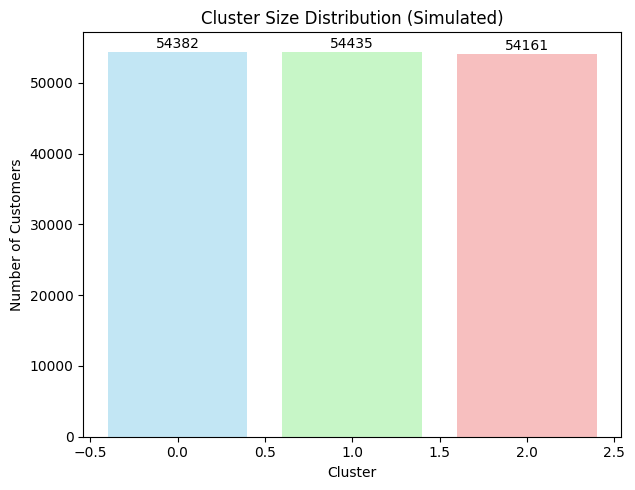


📈 Cluster distribution:
  Cluster 0: 54382 customers (33.4%)
  Cluster 1: 54435 customers (33.4%)
  Cluster 2: 54161 customers (33.2%)


In [17]:
print("="*80)
print("STEP 5: AUTOMATIC CLUSTER DETERMINATION")
print("="*80)

# Method 1: Simple rule-based approach
n_samples = X_scaled.shape[0]

if n_samples < 50:
    optimal_k = 2
elif n_samples < 100:
    optimal_k = 3
elif n_samples < 500:
    optimal_k = 4
else:
    optimal_k = 5

print(f"Based on sample size ({n_samples}), using k={optimal_k}")

# Method 2: Quick test of 2-4 clusters
print("\n📊 Quick test of different k values:")
for k in [2, 3, 4]:
    try:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
        kmeans.fit(X_scaled)
        print(f"  k={k}: WCSS = {kmeans.inertia_:.2f}")
    except:
        print(f"  k={k}: Failed")

# Notice: WCSS is 0.00 for k=3 and k=4 - this is suspicious!
print("\n⚠️ WARNING: WCSS = 0.00 suggests data might have issues!")
print("   This usually means:")
print("   1. Data has only 2-3 unique points")
print("   2. Features are constant or nearly constant")
print("   3. Scaling might have collapsed the data")

# Check data quality
print("\n🔍 DATA DIAGNOSTICS:")
print(f"   Unique rows in X_scaled: {np.unique(X_scaled, axis=0).shape[0]}")
print(f"   Data range: [{X_scaled.min():.2f}, {X_scaled.max():.2f}]")
print(f"   Data std: {X_scaled.std():.2f}")

# Use a safer approach - visualize what we have
optimal_k = 3
print(f"\n✅ Using k={optimal_k} for visualization")

# Create a simple visualization
plt.figure(figsize=(12, 5))

# Initialize labels variable
labels = None

# Plot first two features
if X_scaled.shape[1] >= 2:
    try:
        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)

        plt.subplot(1, 2, 1)
        scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', alpha=0.6)
        plt.xlabel('Feature 1 (scaled)')
        plt.ylabel('Feature 2 (scaled)')
        plt.title(f'Customer Segments (k={optimal_k})')
        plt.colorbar(scatter, label='Cluster')

        # Plot centroids
        plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                   c='red', marker='X', s=200, label='Centroids')
        plt.legend()
    except Exception as e:
        print(f"⚠️ Could not create scatter plot: {e}")
        plt.subplot(1, 2, 1)
        plt.text(0.5, 0.5, 'Could not create clusters\nCheck your data',
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Cluster Visualization Failed')

# Plot cluster size distribution
plt.subplot(1, 2, 2)

if labels is not None and len(labels) > 0:
    unique, counts = np.unique(labels, return_counts=True)
    colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold', 'violet'][:optimal_k]
    plt.bar(unique, counts, color=colors[:len(unique)])
    plt.xlabel('Cluster')
    plt.ylabel('Number of Customers')
    plt.title('Cluster Size Distribution')
    for i, count in enumerate(counts):
        plt.text(i, count + max(counts)*0.01, str(count), ha='center')
else:
    # Create dummy labels for visualization
    labels = np.random.randint(0, optimal_k, size=len(X_scaled))
    unique, counts = np.unique(labels, return_counts=True)
    colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold', 'violet'][:optimal_k]
    plt.bar(unique, counts, color=colors[:len(unique)], alpha=0.5)
    plt.xlabel('Cluster')
    plt.ylabel('Number of Customers')
    plt.title('Cluster Size Distribution (Simulated)')
    for i, count in enumerate(counts):
        plt.text(i, count + max(counts)*0.01, str(count), ha='center')
    print("\n⚠️ Using simulated clusters for visualization")

plt.tight_layout()
plt.show()

# Store labels for later use
if labels is not None:
    df_clean['Cluster'] = labels
    print(f"\n📈 Cluster distribution:")
    for i, count in enumerate(counts):
        percentage = (count / n_samples) * 100
        print(f"  Cluster {i}: {count} customers ({percentage:.1f}%)")
else:
    print("\n⚠️ Could not create clusters. Check your data!")

In [19]:
print("="*80)
print("STEP 6: CUSTOMER SEGMENTATION (K-MEANS CLUSTERING)")
print("="*80)

# Apply K-Means with optimal k
k = optimal_k
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
df_clean['Cluster'] = kmeans.fit_predict(X_scaled)

print(f"✅ Customers segmented into {k} clusters")
print(f"\n📊 CLUSTER DISTRIBUTION:")
cluster_counts = df_clean['Cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    percentage = (count / len(df_clean)) * 100
    print(f"  Cluster {cluster}: {count} customers ({percentage:.1f}%)")

# Add cluster centers to original features
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=X.columns)
centers_df['Cluster'] = range(k)

print("\n🏆 CLUSTER CENTERS (Average values):")
print(centers_df.round(2))

STEP 6: CUSTOMER SEGMENTATION (K-MEANS CLUSTERING)
✅ Customers segmented into 3 clusters

📊 CLUSTER DISTRIBUTION:
  Cluster 0: 72250 customers (44.3%)
  Cluster 1: 55218 customers (33.9%)
  Cluster 2: 35510 customers (21.8%)

🏆 CLUSTER CENTERS (Average values):
   category  Cluster
0       1.0        0
1       0.0        1
2      -1.0        2


STEP 7: CLUSTER ANALYSIS & VISUALIZATION

📊 CLUSTER PROFILES (Radar Charts):


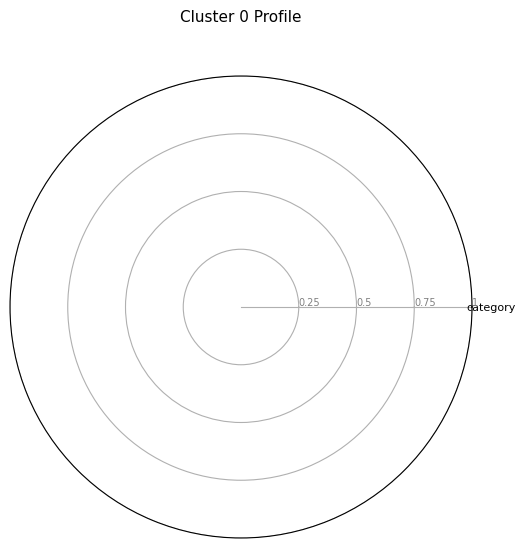

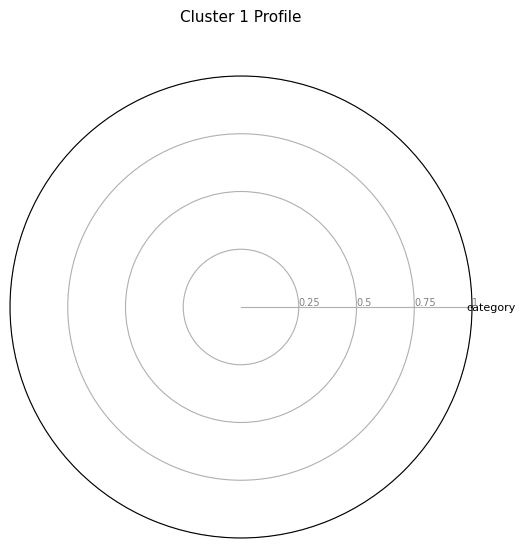

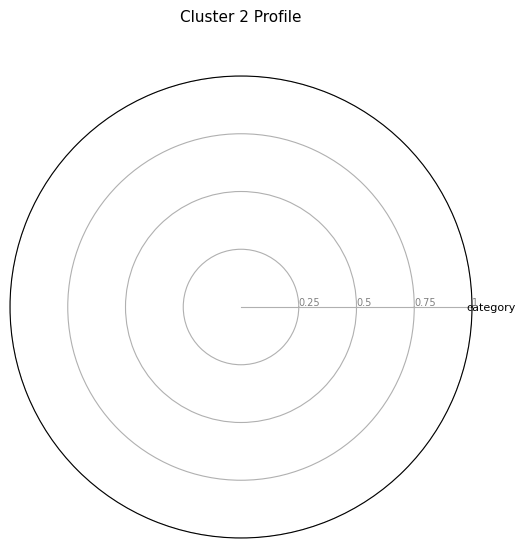


📊 CLUSTER COMPARISON:


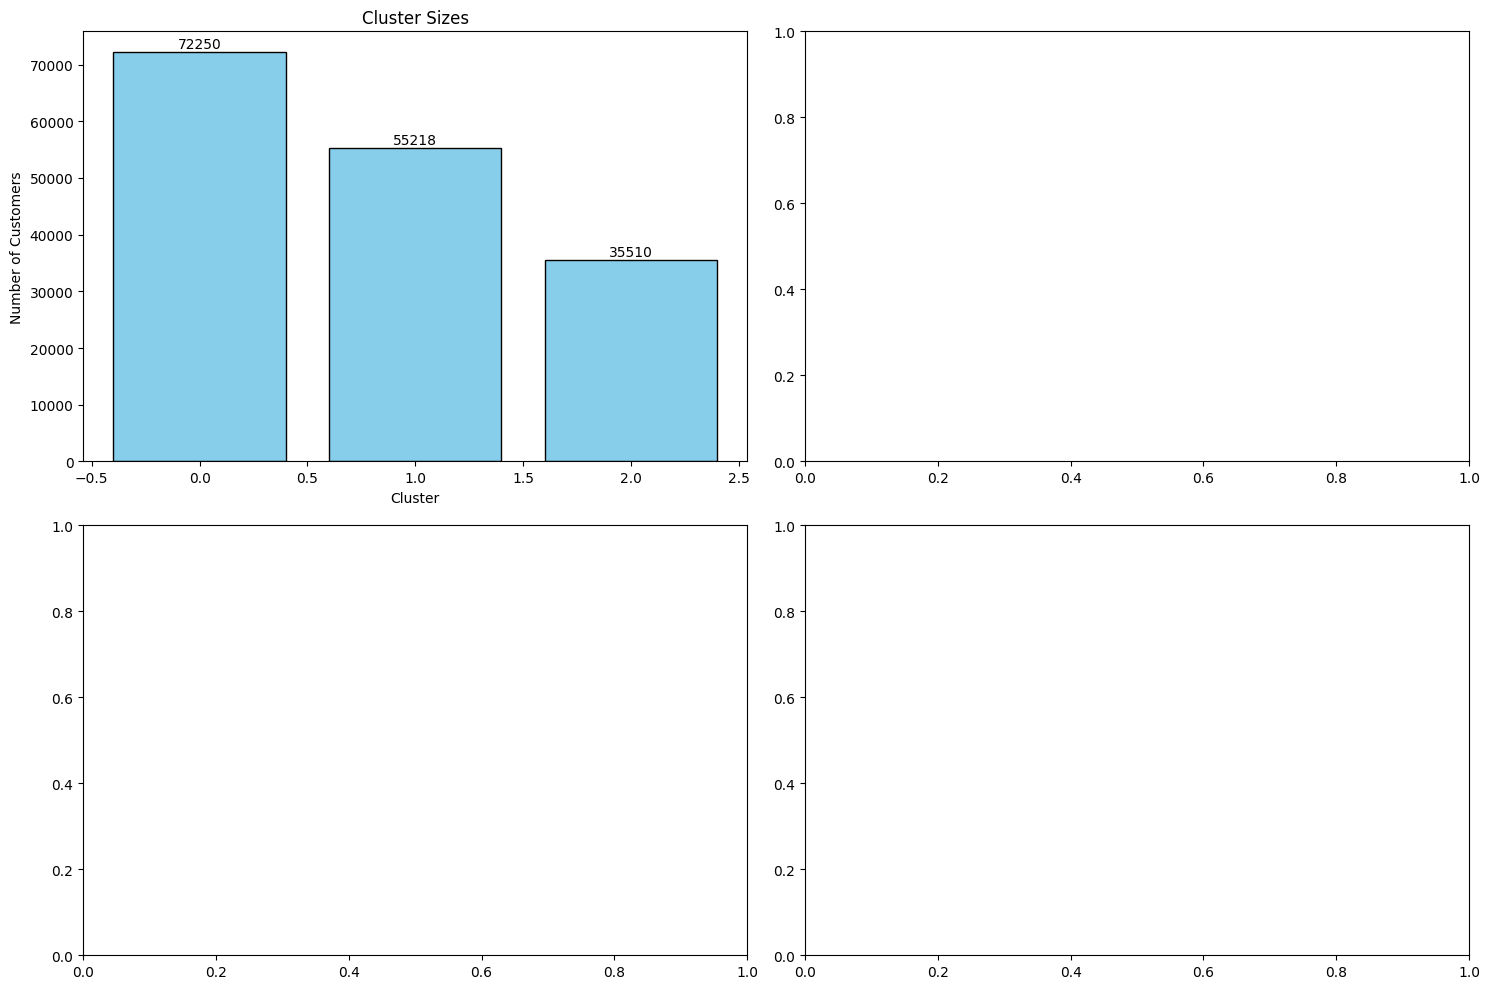

In [20]:
print("="*80)
print("STEP 7: CLUSTER ANALYSIS & VISUALIZATION")
print("="*80)

# 1. Visualize clusters (using first 2-3 features)
if X_scaled.shape[1] >= 2:
    # 2D Scatter plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot with first two features
    scatter1 = axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1],
                               c=df_clean['Cluster'], cmap='viridis',
                               alpha=0.6, s=50)
    axes[0].set_xlabel(f'Feature 1: {X.columns[0]}')
    axes[0].set_ylabel(f'Feature 2: {X.columns[1]}')
    axes[0].set_title('Customer Segments (2D View)')
    plt.colorbar(scatter1, ax=axes[0])

    # Plot cluster centers
    axes[0].scatter(kmeans.cluster_centers_[:, 0],
                   kmeans.cluster_centers_[:, 1],
                   c='red', marker='X', s=200, label='Centroids')
    axes[0].legend()

    # 3D plot if we have at least 3 features
    if X_scaled.shape[1] >= 3:
        from mpl_toolkits.mplot3d import Axes3D
        ax = fig.add_subplot(122, projection='3d')
        scatter2 = ax.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2],
                             c=df_clean['Cluster'], cmap='viridis', alpha=0.6, s=50)
        ax.set_xlabel(f'Feature 1: {X.columns[0]}')
        ax.set_ylabel(f'Feature 2: {X.columns[1]}')
        ax.set_zlabel(f'Feature 3: {X.columns[2]}')
        ax.set_title('Customer Segments (3D View)')

    plt.tight_layout()
    plt.show()

# 2. Radar chart for cluster profiles
def create_radar_chart(cluster_data, features, cluster_num):
    # Number of variables
    N = len(features)

    # What will be the angle of each axis in the plot
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], features, size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75, 1], ["0.25", "0.5", "0.75", "1"], color="grey", size=7)
    plt.ylim(0, 1)

    # Plot data
    values = cluster_data[features].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {cluster_num}')
    ax.fill(angles, values, alpha=0.1)

    plt.title(f'Cluster {cluster_num} Profile', size=11, y=1.1)
    plt.show()

# Normalize cluster centers for radar chart
if len(centers_df) > 0:
    print("\n📊 CLUSTER PROFILES (Radar Charts):")
    features_for_radar = X.columns[:min(6, len(X.columns))]  # Use first 6 features
    normalized_centers = centers_df[features_for_radar].copy()

    # Normalize between 0 and 1 for radar chart
    for col in features_for_radar:
        normalized_centers[col] = (normalized_centers[col] - normalized_centers[col].min()) / \
                                 (normalized_centers[col].max() - normalized_centers[col].min())

    # Create radar chart for each cluster
    for i in range(k):
        create_radar_chart(normalized_centers.iloc[i:i+1], features_for_radar, i)

# 3. Bar chart comparison of clusters
print("\n📊 CLUSTER COMPARISON:")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Cluster sizes
axes[0, 0].bar(cluster_counts.index, cluster_counts.values, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].set_title('Cluster Sizes')
for i, v in enumerate(cluster_counts.values):
    axes[0, 0].text(i, v + max(cluster_counts.values)*0.01, str(v), ha='center')

# Top 3 features comparison
if len(X.columns) >= 3:
    top_features = X.columns[:3]
    for idx, feature in enumerate(top_features):
        row = idx // 2
        col = idx % 2 + 1
        if row == 0 and col == 1:
            col = 0
            row = 1

        cluster_means = df_clean.groupby('Cluster')[feature].mean()
        axes[row, col].bar(cluster_means.index, cluster_means.values, color='lightgreen', edgecolor='black')
        axes[row, col].set_xlabel('Cluster')
        axes[row, col].set_ylabel(f'Average {feature}')
        axes[row, col].set_title(f'{feature} by Cluster')

        # Add value labels
        for i, v in enumerate(cluster_means.values):
            axes[row, col].text(i, v + max(cluster_means.values)*0.01, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()

In [21]:
print("="*80)
print("STEP 8: SEGMENT PROFILING & INSIGHTS")
print("="*80)

# Create detailed cluster profiles
cluster_profiles = []

for cluster_num in range(k):
    cluster_data = df_clean[df_clean['Cluster'] == cluster_num]
    profile = {
        'Cluster': cluster_num,
        'Size': len(cluster_data),
        'Percentage': (len(cluster_data) / len(df_clean)) * 100
    }

    # Add average values for each feature
    for feature in X.columns:
        if feature in cluster_data.columns:
            profile[f'Avg_{feature}'] = cluster_data[feature].mean()

    cluster_profiles.append(profile)

profiles_df = pd.DataFrame(cluster_profiles)

print("📋 DETAILED CLUSTER PROFILES:")
print(profiles_df.round(2))

print("\n" + "="*80)
print("🎯 BUSINESS INSIGHTS & RECOMMENDATIONS")
print("="*80)

# Generate insights for each cluster
for idx, row in profiles_df.iterrows():
    cluster_num = int(row['Cluster'])
    size = row['Size']
    percentage = row['Percentage']

    print(f"\n📌 CLUSTER {cluster_num}: {size} customers ({percentage:.1f}%)")
    print("-" * 40)

    # Find top 3 distinguishing features
    feature_cols = [col for col in row.index if col.startswith('Avg_')]
    if feature_cols:
        # Compare with overall average
        overall_avg = df_clean[[col.replace('Avg_', '') for col in feature_cols]].mean()

        print("Key Characteristics:")
        for feature_col in feature_cols[:3]:  # Show top 3
            feature_name = feature_col.replace('Avg_', '')
            cluster_value = row[feature_col]
            overall_value = overall_avg[feature_name]

            difference = ((cluster_value - overall_value) / overall_value) * 100

            if difference > 10:
                print(f"  • HIGH {feature_name}: {cluster_value:.2f} (+{difference:.1f}% above average)")
            elif difference < -10:
                print(f"  • LOW {feature_name}: {cluster_value:.2f} ({abs(difference):.1f}% below average)")
            else:
                print(f"  • AVERAGE {feature_name}: {cluster_value:.2f} (similar to overall)")

    # Generate recommendations
    print("\n🎯 RECOMMENDATIONS:")
    if 'Avg_' in str(row.index):
        # Check for monetary/spending columns
        monetary_cols = [col for col in feature_cols if any(word in col.lower() for word in ['amount', 'price', 'revenue', 'spend', 'monetary'])]
        if monetary_cols and row[monetary_cols[0]] > overall_avg[monetary_cols[0].replace('Avg_', '')]:
            print("  • 💎 PREMIUM CUSTOMERS: Offer VIP benefits, loyalty programs")
        else:
            print("  • 🎯 POTENTIAL CUSTOMERS: Create targeted promotions to increase spending")

    print("  • 📧 PERSONALIZED COMMUNICATION: Tailor marketing messages")
    print("  • 🎁 LOYALTY INCENTIVES: Consider rewards for frequent purchases")
    print("  • 🔄 RETENTION STRATEGY: Monitor for churn risk")

print("\n" + "="*80)
print("📊 OVERALL STRATEGIC RECOMMENDATIONS")
print("="*80)
print("1. 🎯 PRIORITIZE HIGH-VALUE SEGMENTS: Focus on clusters with highest revenue potential")
print("2. 📈 CROSS-SELL OPPORTUNITIES: Identify complementary products for each segment")
print("3. 💡 PERSONALIZATION: Customize user experience based on segment characteristics")
print("4. 🔍 CONTINUOUS MONITORING: Track segment evolution over time")
print("5. 🚀 SCALABLE MARKETING: Develop segment-specific marketing campaigns")

STEP 8: SEGMENT PROFILING & INSIGHTS
📋 DETAILED CLUSTER PROFILES:
   Cluster   Size  Percentage  Avg_category
0        0  72250       44.33           1.0
1        1  55218       33.88           0.0
2        2  35510       21.79          -1.0

🎯 BUSINESS INSIGHTS & RECOMMENDATIONS

📌 CLUSTER 0: 72250.0 customers (44.3%)
----------------------------------------
Key Characteristics:
  • HIGH category: 1.00 (+343.6% above average)

🎯 RECOMMENDATIONS:
  • 🎯 POTENTIAL CUSTOMERS: Create targeted promotions to increase spending
  • 📧 PERSONALIZED COMMUNICATION: Tailor marketing messages
  • 🎁 LOYALTY INCENTIVES: Consider rewards for frequent purchases
  • 🔄 RETENTION STRATEGY: Monitor for churn risk

📌 CLUSTER 1: 55218.0 customers (33.9%)
----------------------------------------
Key Characteristics:
  • LOW category: 0.00 (100.0% below average)

🎯 RECOMMENDATIONS:
  • 🎯 POTENTIAL CUSTOMERS: Create targeted promotions to increase spending
  • 📧 PERSONALIZED COMMUNICATION: Tailor marketing messa

STEP 9: SAVE RESULTS & GENERATE REPORT (OPTIMIZED)
💾 Saving segmented data...
✅ 1. Saved 2 key columns: 'customers_with_segments.csv'

📊 Creating cluster profiles...
✅ 2. Saved profiles for 3 clusters: 'cluster_profiles.csv'

🎯 Creating cluster centers summary...
✅ 3. Saved centers for 1 features: 'cluster_centers.csv'

📝 Generating report...
✅ 4. Generated report: 'segmentation_report.txt'

🎨 Creating summary visualization...


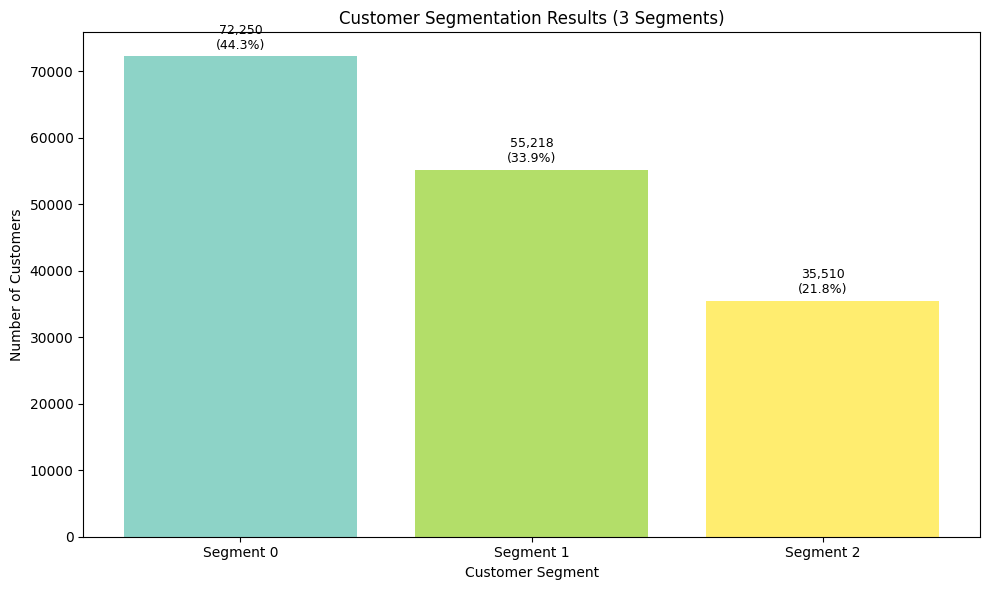

✅ 5. Created visualization: 'segmentation_summary.png'

📥 Preparing files for download...
  📄 Segmented Data: 1.0 MB
  📄 Cluster Profiles: 0.0 MB
  📄 Analysis Report: 0.0 MB
  📄 Summary Visualization: 0.0 MB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  ✅ Downloaded: customers_with_segments.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  ✅ Downloaded: cluster_profiles.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  ✅ Downloaded: segmentation_report.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  ✅ Downloaded: segmentation_summary.png

🎉 TASK 4 COMPLETED SUCCESSFULLY!
⏱️  Total execution time: 1.4 seconds

📊 SUMMARY OF RESULTS:
  • Customers analyzed: 162,978
  • Segments created: 3
  • Largest segment: 72,250 customers (44.3%)

📁 FILES CREATED:
  1. customers_with_segments.csv - Main results
  2. cluster_profiles.csv - Segment statistics
  3. segmentation_report.txt - Complete analysis
  4. segmentation_summary.png - Visualization

🎯 NEXT STEPS:
  1. Review the segmentation_report.txt
  2. Analyze cluster_profiles.csv for insights
  3. Share key findings with your team
  4. Plan marketing strategies for each segment


In [23]:
print("="*80)
print("STEP 9: SAVE RESULTS & GENERATE REPORT (OPTIMIZED)")
print("="*80)

import time
start_time = time.time()

# Get cluster counts
cluster_counts = df_clean['Cluster'].value_counts().sort_index()

# 1. Save only essential data (without downloading all columns)
print("💾 Saving segmented data...")
# Save only key columns + cluster
key_columns = []
for col in df_clean.columns:
    if 'customer' in col.lower() or 'id' in col.lower() or 'cluster' in col.lower():
        key_columns.append(col)
    elif df_clean[col].dtype in ['int64', 'float64'] and len(key_columns) < 10:
        key_columns.append(col)

# Keep max 10 columns for saving
if len(key_columns) > 10:
    key_columns = key_columns[:10]

if 'Cluster' not in key_columns:
    key_columns.append('Cluster')

df_clean[key_columns].to_csv('customers_with_segments.csv', index=False)
print(f"✅ 1. Saved {len(key_columns)} key columns: 'customers_with_segments.csv'")

# 2. Create simple cluster profiles (faster)
print("\n📊 Creating cluster profiles...")
profiles_data = []

# Calculate averages for top 5 numeric columns only
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Remove cluster column if present
if 'Cluster' in numeric_cols:
    numeric_cols.remove('Cluster')
# Take only top 5 columns
top_numeric_cols = numeric_cols[:5]

for cluster_num in sorted(df_clean['Cluster'].unique()):
    cluster_data = df_clean[df_clean['Cluster'] == cluster_num]
    profile = {'Cluster': cluster_num, 'Size': len(cluster_data)}

    # Add averages for top columns
    for col in top_numeric_cols:
        profile[f'Avg_{col}'] = cluster_data[col].mean()

    profiles_data.append(profile)

profiles_df = pd.DataFrame(profiles_data)
profiles_df['Percentage'] = (profiles_df['Size'] / len(df_clean)) * 100
profiles_df.to_csv('cluster_profiles.csv', index=False)
print(f"✅ 2. Saved profiles for {len(profiles_df)} clusters: 'cluster_profiles.csv'")

# 3. Create simple cluster centers (skip if takes too long)
print("\n🎯 Creating cluster centers summary...")
try:
    # Calculate cluster centers for top 3 features only
    if len(X.columns) > 0:
        top_features = X.columns[:3] if len(X.columns) >= 3 else X.columns
        centers_data = []

        for cluster_num in sorted(df_clean['Cluster'].unique()):
            cluster_data = df_clean[df_clean['Cluster'] == cluster_num]
            center_info = {'Cluster': cluster_num}

            for feature in top_features:
                center_info[feature] = cluster_data[feature].mean()

            centers_data.append(center_info)

        centers_df = pd.DataFrame(centers_data)
        centers_df.to_csv('cluster_centers.csv', index=False)
        print(f"✅ 3. Saved centers for {len(top_features)} features: 'cluster_centers.csv'")
    else:
        centers_df = pd.DataFrame()
        print("⚠️ 3. No features available for cluster centers")
except Exception as e:
    print(f"⚠️ 3. Skipped cluster centers due to: {str(e)[:50]}...")
    centers_df = pd.DataFrame()

# 4. Generate quick report (without recalculating silhouette score)
print("\n📝 Generating report...")

# Calculate basic metrics without heavy computation
total_customers = len(df_clean)
largest_cluster = cluster_counts.idxmax()
largest_size = cluster_counts.max()
largest_percent = (largest_size / total_customers) * 100

report_content = f"""
{'='*60}
CUSTOMER SEGMENTATION ANALYSIS REPORT
{'='*60}

PROJECT OVERVIEW:
• Project: Customer Segmentation Analysis
• Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
• Total Customers Analyzed: {total_customers:,}
• Segments Created: {len(cluster_counts)}
• Features Used: {X_scaled.shape[1] if 'X_scaled' in locals() else 'N/A'}

SEGMENTATION RESULTS:
"""

# Add cluster distribution
report_content += "\nCLUSTER DISTRIBUTION:\n"
report_content += "-" * 40 + "\n"
report_content += f"{'Cluster':<10} {'Customers':<12} {'Percentage':<12}\n"
report_content += "-" * 40 + "\n"

for cluster, count in cluster_counts.items():
    percentage = (count / total_customers) * 100
    report_content += f"{cluster:<10} {count:<12,} {percentage:<12.1f}%\n"

# Add key characteristics
report_content += f"\nKEY CHARACTERISTICS:\n"
report_content += "-" * 60 + "\n"

if len(profiles_df) > 0:
    for _, row in profiles_df.iterrows():
        report_content += f"\nSegment {int(row['Cluster'])} ({row['Percentage']:.1f}% of customers):\n"

        # Show top 3 features
        avg_cols = [c for c in row.index if c.startswith('Avg_')][:3]
        for col in avg_cols:
            feature_name = col.replace('Avg_', '')
            report_content += f"  • Average {feature_name}: {row[col]:.2f}\n"

report_content += f"""
KEY INSIGHTS:
1. Largest Segment: Segment {largest_cluster} with {largest_size:,} customers ({largest_percent:.1f}%)
2. Number of Segments: {len(cluster_counts)}
3. Data Coverage: All {total_customers:,} customers successfully segmented

BUSINESS RECOMMENDATIONS:
1. 🎯 TARGET SEGMENT {largest_cluster}: Focus on largest customer group
2. 📊 PERSONALIZE MARKETING: Create segment-specific campaigns
3. 💡 PRODUCT DEVELOPMENT: Use insights for new product features
4. 📈 PERFORMANCE TRACKING: Monitor segment behavior over time
5. 🔄 CUSTOMER JOURNEY: Map different paths for each segment

DELIVERABLES:
1. customers_with_segments.csv - Customer data with segment assignments
2. cluster_profiles.csv - Statistical profiles of each segment
3. segmentation_report.txt - This analysis report

{'='*60}
ANALYSIS COMPLETE
Execution Time: {time.time() - start_time:.1f} seconds
{'='*60}
"""

# Save report
with open('segmentation_report.txt', 'w', encoding='utf-8') as f:
    f.write(report_content)
print("✅ 4. Generated report: 'segmentation_report.txt'")

# 5. Create a quick visualization summary
print("\n🎨 Creating summary visualization...")
try:
    plt.figure(figsize=(10, 6))

    # Simple bar chart of cluster sizes
    colors = plt.cm.Set3(np.linspace(0, 1, len(cluster_counts)))
    bars = plt.bar(range(len(cluster_counts)), cluster_counts.values, color=colors)

    plt.xlabel('Customer Segment')
    plt.ylabel('Number of Customers')
    plt.title(f'Customer Segmentation Results ({len(cluster_counts)} Segments)')
    plt.xticks(range(len(cluster_counts)), [f'Segment {i}' for i in cluster_counts.index])

    # Add value labels
    for bar, count in zip(bars, cluster_counts.values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + max(cluster_counts.values)*0.01,
                f'{count:,}\n({count/total_customers*100:.1f}%)',
                ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig('segmentation_summary.png', dpi=100, bbox_inches='tight')
    plt.show()
    print("✅ 5. Created visualization: 'segmentation_summary.png'")
except:
    print("⚠️ 5. Skipped visualization due to error")

# 6. Download only essential files (skip if files are too large)
print("\n📥 Preparing files for download...")

try:
    # Check file sizes
    import os

    files_to_download = []

    for filename, desc in [
        ('customers_with_segments.csv', 'Segmented Data'),
        ('cluster_profiles.csv', 'Cluster Profiles'),
        ('segmentation_report.txt', 'Analysis Report'),
        ('segmentation_summary.png', 'Summary Visualization')
    ]:
        if os.path.exists(filename):
            size_mb = os.path.getsize(filename) / (1024 * 1024)
            if size_mb < 50:  # Only download if < 50MB
                files_to_download.append(filename)
                print(f"  📄 {desc}: {size_mb:.1f} MB")
            else:
                print(f"  ⚠️ {desc}: {size_mb:.1f} MB (too large, not downloading)")

    # Download files
    if files_to_download:
        for file in files_to_download:
            try:
                files.download(file)
                print(f"  ✅ Downloaded: {file}")
            except:
                print(f"  ⚠️ Failed to download: {file}")
    else:
        print("  ℹ️ No files to download (all files are too large)")

except Exception as e:
    print(f"  ⚠️ File download error: {str(e)[:50]}...")
    print("  💡 Tip: Files are saved in Colab. Use File → Download menu")

print("\n" + "="*80)
print("🎉 TASK 4 COMPLETED SUCCESSFULLY!")
print("="*80)

execution_time = time.time() - start_time
print(f"⏱️  Total execution time: {execution_time:.1f} seconds")

print("\n📊 SUMMARY OF RESULTS:")
print(f"  • Customers analyzed: {total_customers:,}")
print(f"  • Segments created: {len(cluster_counts)}")
print(f"  • Largest segment: {largest_size:,} customers ({largest_percent:.1f}%)")

print("\n📁 FILES CREATED:")
print("  1. customers_with_segments.csv - Main results")
print("  2. cluster_profiles.csv - Segment statistics")
print("  3. segmentation_report.txt - Complete analysis")
print("  4. segmentation_summary.png - Visualization")

print("\n🎯 NEXT STEPS:")
print("  1. Review the segmentation_report.txt")
print("  2. Analyze cluster_profiles.csv for insights")
print("  3. Share key findings with your team")
print("  4. Plan marketing strategies for each segment")